In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from src.model.models import Diffusion, DBModelBig, DBModelSmall
from src.data.datasets import ModelParamsDataset
from src.data.helpers import get_moons_dataset, rotate, get_accuracy, add_noise, reconstruct_xt, generate_diffusion, find_closest_vectors
from src.visualization.visualize import plot_decision_boundary

import timeit

## Regular (10000 Samples per angle)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 1e-3
epochs = 1000
num_timesteps = 1000
batch_size = 128
beta_schedule = "linear"
betas = torch.tensor(np.linspace(1e-4, 0.02, num_timesteps), dtype=torch.float32)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
diffusion = Diffusion()
diffusion.to(device)

optimizer = torch.optim.AdamW(diffusion.parameters(), lr=lr)

save_path = "../../models/generators/diffusion/"
model_path = save_path + "diffusion_conditional.pth"

In [ ]:
diffusion.train()

angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
accuracies_per_epoch = []

losses = []

for epoch in tqdm(range(epochs)):
    for (X, y) in dataloader:
        noise = torch.randn(X.shape)
        timesteps = torch.randint(0, num_timesteps, (X.shape[0],)).long()

        y = y * torch.pi / 180
        sin = torch.sin(y)
        cos = torch.cos(y)
        angle = torch.cat([sin[:, None], cos[:, None]], dim=1)

        noisy = add_noise(X, noise, alphas_cumprod, timesteps)

        timesteps = timesteps.to(device)
        angle = angle.to(device)
        noisy = noisy.to(device)
        noise = noise.to(device)

        noise_pred = diffusion(noisy, timesteps, angle)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    if(epoch % 20 == 0):
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(diffusion.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 0.390062540769577
Epoch 20: Loss 0.3106726109981537
Epoch 40: Loss 0.3278266191482544
Epoch 60: Loss 0.3101356327533722
Epoch 80: Loss 0.313618004322052
Epoch 100: Loss 0.31750574707984924
Epoch 120: Loss 0.2719688415527344
Epoch 140: Loss 0.27546241879463196
Epoch 160: Loss 0.33038216829299927
Epoch 180: Loss 0.2550548315048218
Epoch 200: Loss 0.31752488017082214
Epoch 220: Loss 0.27044323086738586
Epoch 240: Loss 0.2911543548107147
Epoch 260: Loss 0.2772878110408783
Epoch 280: Loss 0.25343063473701477
Epoch 300: Loss 0.23040473461151123
Epoch 320: Loss 0.22507594525814056
Epoch 340: Loss 0.24440936744213104
Epoch 360: Loss 0.30992862582206726
Epoch 380: Loss 0.24380406737327576
Epoch 400: Loss 0.21301838755607605
Epoch 420: Loss 0.27425938844680786
Epoch 440: Loss 0.27799853682518005
Epoch 460: Loss 0.25054335594177246
Epoch 480: Loss 0.30128908157348633
Epoch 500: Loss 0.19177380204200745
Epoch 520: Loss 0.22729244828224182
Epoch 540: Loss 0.24389788508415222
Epoch 560

In [4]:
model = Diffusion()
model.load_state_dict(torch.load(model_path))
model.eval()

Diffusion(
  (time_mlp): SinusoidalEmbedding()
  (layers): Sequential(
    (0): Linear(in_features=163, out_features=1024, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=1024, out_features=33, bias=True)
  )
)

  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1050.164339400002
Mean accuracy: 98.02
Standard deviation: 5.49561643494158
The distance in set: 14.99246859550476 0.5711874483855768
The distance between generated samples and training samples: 1.30386121571064 0.18629558046917344


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1075.4968960000006
Mean accuracy: 80.904875
Standard deviation: 13.547867497668221
The distance in set: 14.337817430496216 0.17788474462315954
The distance between generated samples and training samples: 6.7929675579071045 0.22345220646625064


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1073.0578125999964
Mean accuracy: 87.33200000000001
Standard deviation: 11.866519118932898
The distance in set: 16.0505508184433 0.2794844707636665
The distance between generated samples and training samples: 6.734345555305481 0.1885156432856542


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1054.3879965000015
Mean accuracy: 95.02050000000001
Standard deviation: 6.754891172328389
The distance in set: 17.31632900238037 0.3325281863406275
The distance between generated samples and training samples: 6.920777797698975 0.16202616773437675


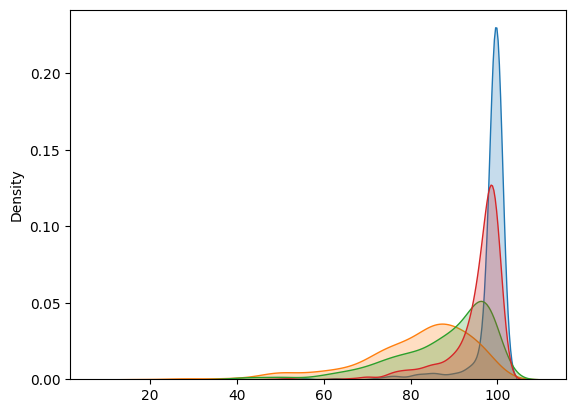

In [5]:
indexes = ["_10spa", "_100spa", "_1000spa", ""]
for index in indexes:
    model_path = f"../../models/generators/diffusion/diffusion_conditional{index}.pth"
    model = Diffusion()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    db = DBModelSmall(batch_first=F)

    angles = [0, 45, 90, 135, 180, 225, 270, 315]
    samples_per_angle = 100

    accuracies = []
    generated_parameters = []

    torch.manual_seed(42)

    start_time = timeit.default_timer()
    with torch.no_grad():
        for angle in tqdm(angles):
            good_parameters = []
            for i in range(samples_per_angle):
                sample = generate_diffusion(model, angle)

                X, y = get_moons_dataset()
                X_rotated = rotate(X, angle)
                X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                db.set_weights(sample)
                accuracy = get_accuracy(db, X_rotated, y)
                accuracies.append(accuracy)
                if(accuracy > 80):
                    good_parameters.append(sample)
            
            generated_parameters.append(good_parameters)

    elapsed_time = timeit.default_timer() - start_time
    print(f"Time to generate {samples_per_angle*len(angles)} samples:", elapsed_time)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        dists = torch.cdist(params, params)
        average_dist = torch.mean(dists)
        average_distances.append(average_dist.item())

    set_distances_mean = np.mean(average_distances)
    set_distances_std = np.std(average_distances)

    train_params = []
    for params, angle in dataset:
        train_params.append(params)
    train_params = torch.stack(train_params)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        closest_vals,_ = find_closest_vectors(params, train_params)
        average = torch.mean(closest_vals)
        average_distances.append(average.item())

    closest_distances_mean = np.mean(average_distances)
    closest_distances_std = np.std(average_distances)
    
    print("Model:", model_path)
    print("Mean accuracy:", np.mean(accuracies))
    print("Standard deviation:", np.std(accuracies))
    print("The distance in set:", set_distances_mean, set_distances_std)
    print("The distance between generated samples and training samples:", closest_distances_mean, closest_distances_std)
    sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1012.5374450999952
Mean accuracy: 90.18875
Standard deviation: 9.95667105198821
The distance in set: 14.069533348083496 0.3546301740052932
The distance between generated samples and training samples: 3.501913845539093 0.35087992257527495


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1040.1435227000038
Mean accuracy: 81.694625
Standard deviation: 12.263064813062638
The distance in set: 14.340670228004456 0.12694082251471264
The distance between generated samples and training samples: 6.823520839214325 0.21024034387063376


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1009.4811131999959
Mean accuracy: 87.23475
Standard deviation: 11.485614586842969
The distance in set: 15.828927159309387 0.388942969458186
The distance between generated samples and training samples: 7.016666352748871 0.12923051302805605


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1026.366076899998
Mean accuracy: 94.50299999999999
Standard deviation: 7.145006368086736
The distance in set: 16.779057025909424 0.3573281548912649
The distance between generated samples and training samples: 7.185138463973999 0.09611558760744059


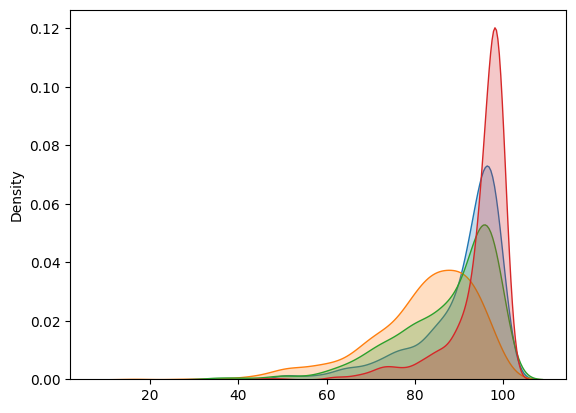

In [ ]:
indexes = ["_10spa", "_100spa", "_1000spa", ""]
for index in indexes:
    model_path = f"../../models/generators/diffusion/diffusion_conditional{index}.pth"
    model = Diffusion()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    db = DBModelBig(batch_first=False)

    angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
    samples_per_angle = 100

    accuracies = []
    generated_parameters = []

    torch.manual_seed(42)

    start_time = timeit.default_timer()
    with torch.no_grad():
        for angle in tqdm(angles):
            good_parameters = []
            for i in range(samples_per_angle):
                sample = generate_diffusion(model, angle)

                X, y = get_moons_dataset()
                X_rotated = rotate(X, angle)
                X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                db.set_weights(sample)
                accuracy = get_accuracy(db, X_rotated, y)
                accuracies.append(accuracy)
                if(accuracy > 80):
                    good_parameters.append(sample)
            
            generated_parameters.append(good_parameters)

    elapsed_time = timeit.default_timer() - start_time
    print(f"Time to generate {samples_per_angle*len(angles)} samples:", elapsed_time)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        dists = torch.cdist(params, params)
        average_dist = torch.mean(dists)
        average_distances.append(average_dist.item())

    set_distances_mean = np.mean(average_distances)
    set_distances_std = np.std(average_distances)

    train_params = []
    for params, angle in dataset:
        train_params.append(params)
    train_params = torch.stack(train_params)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        closest_vals,_ = find_closest_vectors(params, train_params)
        average = torch.mean(closest_vals)
        average_distances.append(average.item())

    closest_distances_mean = np.mean(average_distances)
    closest_distances_std = np.std(average_distances)

    print("Model:", model_path)
    print("Mean accuracy:", np.mean(accuracies))
    print("Standard deviation:", np.std(accuracies))
    print("The distance in set:", set_distances_mean, set_distances_std)
    print("The distance between generated samples and training samples:", closest_distances_mean, closest_distances_std)
    sns.kdeplot(accuracies, fill=True)

In [6]:
plt.rcParams.update({'font.size': 22})



C:\Users\JetFire\AppData\Local\Temp\ipykernel_10776\2451978923.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


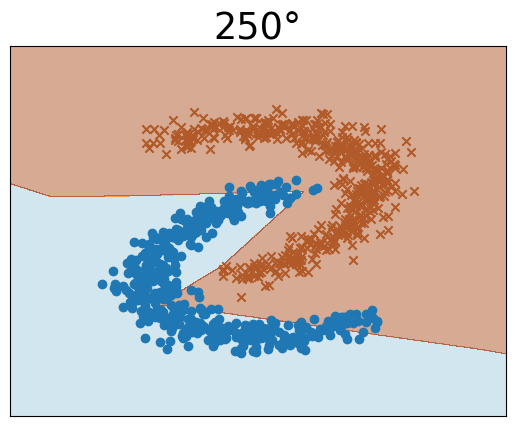

In [13]:
angle = np.random.randint(0, 360)

X, y = get_moons_dataset()
x = generate_diffusion(model, angle)
x = torch.tensor(x, dtype=torch.float32)

X_rotated = rotate(X, angle)
X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

plot_decision_boundary(x, X_rotated, y, title=f"{angle}°", save_path=f"../../reports/more-diffusion-sample-{angle}.pdf", axis=False, legend=False)



## 10 Samples per angle

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 1e-3
epochs = 50000
num_timesteps = 1000
batch_size = 20
beta_schedule = "linear"
betas = torch.tensor(np.linspace(1e-4, 0.02, num_timesteps), dtype=torch.float32)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv", get_per_angle=10)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
diffusion = Diffusion()
diffusion.to(device)

optimizer = torch.optim.AdamW(diffusion.parameters(), lr=lr)

save_path = "../../models/generators/diffusion/"
model_path = save_path + "diffusion_conditional_10spa.pth"

In [6]:
diffusion.train()

losses = []

for epoch in tqdm(range(epochs)):
    for (X, y) in dataloader:
        noise = torch.randn(X.shape)
        timesteps = torch.randint(0, num_timesteps, (X.shape[0],)).long()

        y = y * torch.pi / 180
        sin = torch.sin(y)
        cos = torch.cos(y)
        angle = torch.cat([sin[:, None], cos[:, None]], dim=1)

        noisy = add_noise(X, noise, alphas_cumprod, timesteps)

        timesteps = timesteps.to(device)
        angle = angle.to(device)
        noisy = noisy.to(device)
        noise = noise.to(device)

        noise_pred = diffusion(noisy, timesteps, angle)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    if(epoch % 20 == 0):
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(diffusion.state_dict(), model_path)

  0%|          | 0/50000 [00:00<?, ?it/s]

Epoch 0: Loss 1.0704249143600464
Epoch 20: Loss 0.7604587078094482
Epoch 40: Loss 0.6422911286354065
Epoch 60: Loss 0.6017951369285583
Epoch 80: Loss 0.4716672897338867
Epoch 100: Loss 0.5251448750495911
Epoch 120: Loss 0.5036819577217102
Epoch 140: Loss 0.5362821221351624
Epoch 160: Loss 0.42166459560394287
Epoch 180: Loss 0.4148005545139313
Epoch 200: Loss 0.3103448152542114
Epoch 220: Loss 0.2905287742614746
Epoch 240: Loss 0.2981977164745331
Epoch 260: Loss 0.48536986112594604
Epoch 280: Loss 0.38186460733413696
Epoch 300: Loss 0.30206015706062317
Epoch 320: Loss 0.44411933422088623
Epoch 340: Loss 0.23958313465118408
Epoch 360: Loss 0.2763891816139221
Epoch 380: Loss 0.4330022931098938
Epoch 400: Loss 0.20068666338920593
Epoch 420: Loss 0.3206070363521576
Epoch 440: Loss 0.3362150490283966
Epoch 460: Loss 0.32695698738098145
Epoch 480: Loss 0.2932581901550293
Epoch 500: Loss 0.2770688831806183
Epoch 520: Loss 0.31420087814331055
Epoch 540: Loss 0.2536850869655609
Epoch 560: Loss 0

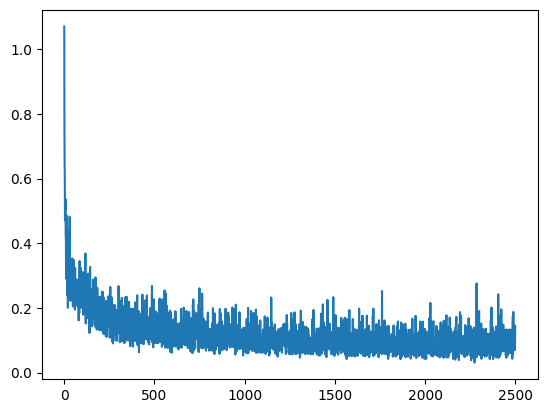

In [7]:
plt.plot(losses)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_5948\461305206.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 97.94675


<Axes: ylabel='Density'>

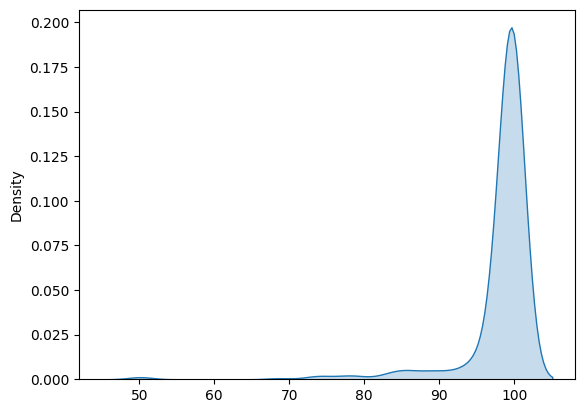

In [8]:
model = Diffusion()
model.load_state_dict(torch.load(model_path))
model.eval()

model = DBModelSmall(batch_first=False)

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(50):
            x = generate_diffusion(model, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            model.set_weights(x)
            accuracy = get_accuracy(model, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_5948\2275798082.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 90.45025000000001


<Axes: ylabel='Density'>

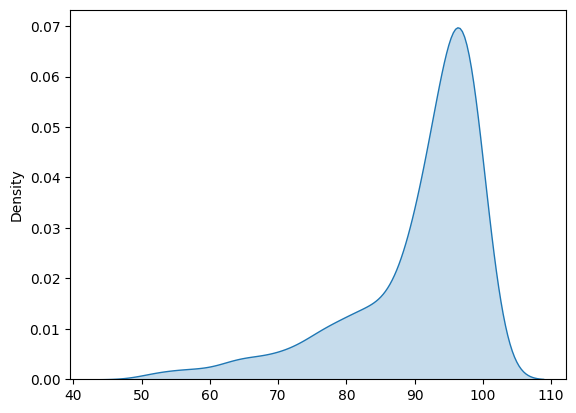

In [9]:
model = Diffusion()
model.load_state_dict(torch.load(model_path))
model.eval()

db = DBModelBig(batch_first=False)

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(50):
            x = generate_diffusion(model, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            db.set_weights(x)
            accuracy = get_accuracy(db, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## 100 Samples per angle

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 1e-3
epochs = 1000
num_timesteps = 1000
batch_size = 100
beta_schedule = "linear"
betas = torch.tensor(np.linspace(1e-4, 0.02, num_timesteps), dtype=torch.float32)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv", get_per_angle=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
diffusion = Diffusion()
diffusion.to(device)

optimizer = torch.optim.AdamW(diffusion.parameters(), lr=lr)

save_path = "../../models/generators/diffusion/"
model_path = save_path + "diffusion_conditional_100spa.pth"

In [11]:
diffusion.train()

losses = []

for epoch in tqdm(range(epochs)):
    for (X, y) in dataloader:
        noise = torch.randn(X.shape)
        timesteps = torch.randint(0, num_timesteps, (X.shape[0],)).long()

        y = y * torch.pi / 180
        sin = torch.sin(y)
        cos = torch.cos(y)
        angle = torch.cat([sin[:, None], cos[:, None]], dim=1)

        noisy = add_noise(X, noise, alphas_cumprod, timesteps)

        timesteps = timesteps.to(device)
        angle = angle.to(device)
        noisy = noisy.to(device)
        noise = noise.to(device)

        noise_pred = diffusion(noisy, timesteps, angle)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    if(epoch % 20 == 0):
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(diffusion.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 0.9171210527420044
Epoch 20: Loss 0.4540427029132843
Epoch 40: Loss 0.42786407470703125
Epoch 60: Loss 0.39913782477378845
Epoch 80: Loss 0.44536006450653076
Epoch 100: Loss 0.43280425667762756
Epoch 120: Loss 0.3424796462059021
Epoch 140: Loss 0.3498683273792267
Epoch 160: Loss 0.3736892640590668
Epoch 180: Loss 0.3882506191730499
Epoch 200: Loss 0.32760465145111084
Epoch 220: Loss 0.27193745970726013
Epoch 240: Loss 0.2955476641654968
Epoch 260: Loss 0.29246455430984497
Epoch 280: Loss 0.31402313709259033
Epoch 300: Loss 0.2438134402036667
Epoch 320: Loss 0.2741277515888214
Epoch 340: Loss 0.27188482880592346
Epoch 360: Loss 0.31415194272994995
Epoch 380: Loss 0.28714054822921753
Epoch 400: Loss 0.238372802734375
Epoch 420: Loss 0.22743484377861023
Epoch 440: Loss 0.24580040574073792
Epoch 460: Loss 0.24471202492713928
Epoch 480: Loss 0.22185008227825165
Epoch 500: Loss 0.25116321444511414
Epoch 520: Loss 0.2714959979057312
Epoch 540: Loss 0.2221008837223053
Epoch 560: 

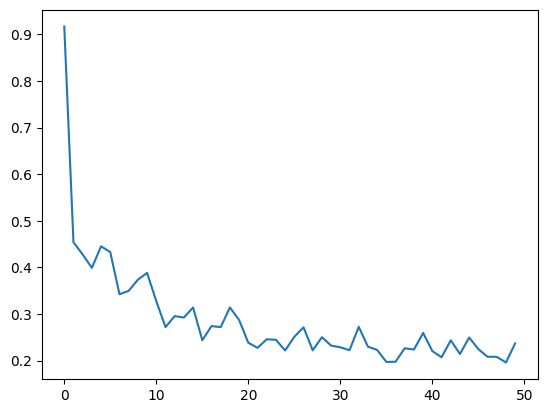

In [12]:
plt.plot(losses)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_11112\461305206.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 81.21175


<Axes: ylabel='Density'>

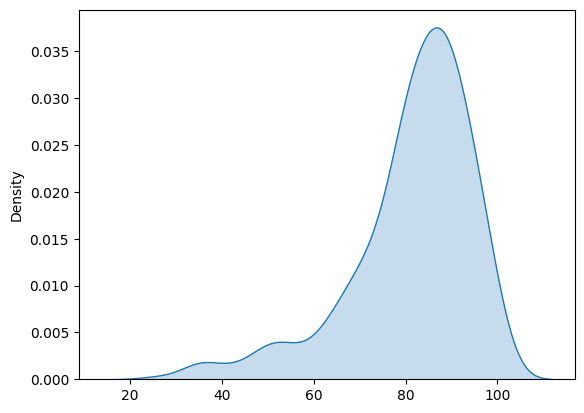

In [13]:
model = Diffusion()
model.load_state_dict(torch.load(model_path))
model.eval()

db = DBModelBig(batch_first=False)

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(50):
            x = generate_diffusion(model, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            db.set_weights(x)
            accuracy = get_accuracy(db, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_11112\2275798082.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 79.26350000000001


<Axes: ylabel='Density'>

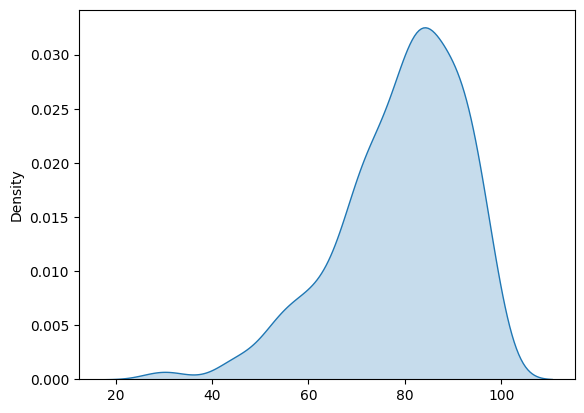

In [14]:
model = Diffusion()
model.load_state_dict(torch.load(model_path))
model.eval()

db = DBModelBig(batch_first=False)

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(50):
            x = generate_diffusion(model, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            db.set_weights(x)
            accuracy = get_accuracy(db, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## 1000 Samples per angle

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 1e-3
epochs = 1000
num_timesteps = 1000
batch_size = 100
beta_schedule = "linear"
betas = torch.tensor(np.linspace(1e-4, 0.02, num_timesteps), dtype=torch.float32)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_small.csv", get_per_angle=1000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
diffusion = Diffusion()
diffusion.to(device)

optimizer = torch.optim.AdamW(diffusion.parameters(), lr=lr)

save_path = "../../models/generators/diffusion/"
model_path = save_path + "diffusion_conditional_1000spa.pth"

In [17]:
diffusion.train()

losses = []

for epoch in tqdm(range(epochs)):
    for (X, y) in dataloader:
        noise = torch.randn(X.shape)
        timesteps = torch.randint(0, num_timesteps, (X.shape[0],)).long()

        y = y * torch.pi / 180
        sin = torch.sin(y)
        cos = torch.cos(y)
        angle = torch.cat([sin[:, None], cos[:, None]], dim=1)

        noisy = add_noise(X, noise, alphas_cumprod, timesteps)

        timesteps = timesteps.to(device)
        angle = angle.to(device)
        noisy = noisy.to(device)
        noise = noise.to(device)

        noise_pred = diffusion(noisy, timesteps, angle)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    if(epoch % 20 == 0):
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(diffusion.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 0.5071443319320679
Epoch 20: Loss 0.38555848598480225
Epoch 40: Loss 0.4118953347206116
Epoch 60: Loss 0.3748788833618164
Epoch 80: Loss 0.38173016905784607
Epoch 100: Loss 0.3406873345375061
Epoch 120: Loss 0.2935694754123688
Epoch 140: Loss 0.3154018819332123
Epoch 160: Loss 0.3243427872657776
Epoch 180: Loss 0.32163769006729126
Epoch 200: Loss 0.33588799834251404
Epoch 220: Loss 0.2853900194168091
Epoch 240: Loss 0.3234531879425049
Epoch 260: Loss 0.31474950909614563
Epoch 280: Loss 0.2576356530189514
Epoch 300: Loss 0.24921344220638275
Epoch 320: Loss 0.26972487568855286
Epoch 340: Loss 0.2947455644607544
Epoch 360: Loss 0.3233703374862671
Epoch 380: Loss 0.3143240213394165
Epoch 400: Loss 0.3366338610649109
Epoch 420: Loss 0.28054940700531006
Epoch 440: Loss 0.25951650738716125
Epoch 460: Loss 0.2510330379009247
Epoch 480: Loss 0.27578961849212646
Epoch 500: Loss 0.2556746304035187
Epoch 520: Loss 0.2637777328491211
Epoch 540: Loss 0.25314515829086304
Epoch 560: Loss

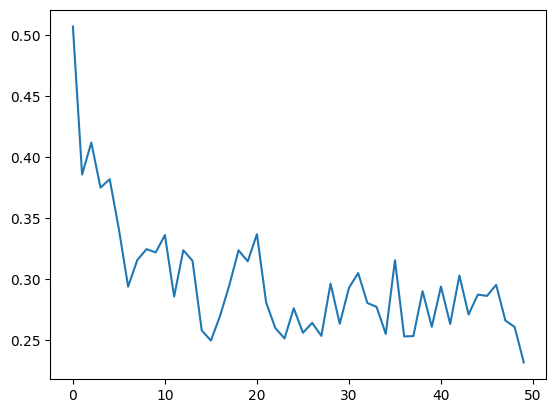

In [20]:
plt.plot(losses)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_11112\461305206.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 86.71825000000001


<Axes: ylabel='Density'>

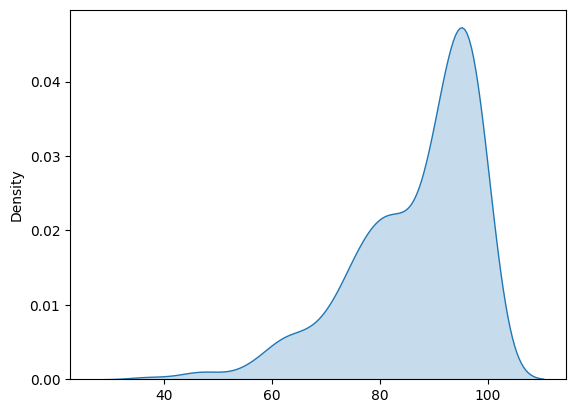

In [18]:
model = Diffusion()
model.load_state_dict(torch.load(model_path))
model.eval()

db = DBModelBig(batch_first=False)

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(50):
            x = generate_diffusion(model, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            db.set_weights(x)
            accuracy = get_accuracy(db, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_11112\2275798082.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 86.93825000000001


<Axes: ylabel='Density'>

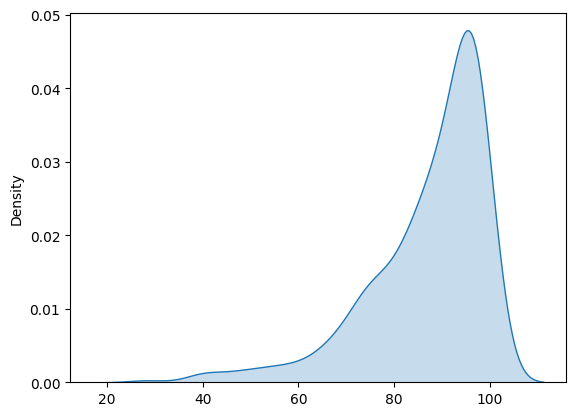

In [19]:
model = Diffusion()
model.load_state_dict(torch.load(model_path))
model.eval()

db = DBModelBig(batch_first=False)

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(50):
            x = generate_diffusion(model, angle)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            db.set_weights(x)
            accuracy = get_accuracy(db, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## Big models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 1e-3
epochs = 500
num_timesteps = 1000
batch_size = 128
beta_schedule = "linear"
betas = torch.tensor(np.linspace(1e-4, 0.02, num_timesteps), dtype=torch.float32)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# Dataset
dataset = ModelParamsDataset("../../data/zoo_big.csv")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
diffusion = Diffusion(input_dim=391, output_dim=261, n_hidden=4, hidden_dim=1000)
diffusion.to(device)

optimizer = torch.optim.AdamW(params=diffusion.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)

save_path = "../../models/generators/diffusion/"
model_path = save_path + "diffusion_conditional_big.pth"

In [3]:
diffusion.train()

angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
accuracies_per_epoch = []

losses = []

for epoch in tqdm(range(epochs)):
    for (X, y) in dataloader:
        noise = torch.randn(X.shape)
        timesteps = torch.randint(0, num_timesteps, (X.shape[0],)).long()

        y = y * torch.pi / 180
        sin = torch.sin(y)
        cos = torch.cos(y)
        angle = torch.cat([sin[:, None], cos[:, None]], dim=1)

        noisy = add_noise(X, noise, alphas_cumprod, timesteps)

        timesteps = timesteps.to(device)
        angle = angle.to(device)
        noisy = noisy.to(device)
        noise = noise.to(device)

        noise_pred = diffusion(noisy, timesteps, angle)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    if(epoch % 20 == 0):
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(diffusion.state_dict(), model_path)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: Loss 0.43783995509147644
Epoch 20: Loss 0.2647387981414795
Epoch 40: Loss 0.2466387301683426
Epoch 60: Loss 0.2566162943840027
Epoch 80: Loss 0.28194910287857056
Epoch 100: Loss 0.3081691265106201
Epoch 120: Loss 0.21618515253067017
Epoch 140: Loss 0.2402416318655014
Epoch 160: Loss 0.25884950160980225
Epoch 180: Loss 0.30798569321632385
Epoch 200: Loss 0.26327425241470337
Epoch 220: Loss 0.20675985515117645
Epoch 240: Loss 0.23023100197315216
Epoch 260: Loss 0.25374114513397217
Epoch 280: Loss 0.23969854414463043
Epoch 300: Loss 0.26967594027519226
Epoch 320: Loss 0.23199889063835144
Epoch 340: Loss 0.2171981781721115
Epoch 360: Loss 0.19103986024856567
Epoch 380: Loss 0.21876487135887146
Epoch 400: Loss 0.2392737865447998
Epoch 420: Loss 0.25419867038726807
Epoch 440: Loss 0.20995710790157318
Epoch 460: Loss 0.21869243681430817
Epoch 480: Loss 0.24060115218162537
